In [84]:
import itertools

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import collections
import argparse
import ast
import sys
import gzip
import csv
import pprint
import pandas as pd
import neet.sensitivity as ns
import neet.boolean as nn
from neet.boolean.examples import c_elegans
from itertools import groupby
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime as dt

from scipy import stats
import scipy as sp
import community
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from matplotlib import patches

from network_ei import *
from causal_emergence import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [3]:
def unbalanced_barbell(n_left, n_right=100, n_connectors=1, p0=0):
    """
    Creates a barbell with n_left=some number less than n_right, connected by n_connectors
    """
    G1 = nx.complete_graph(n_left)
    for i in range(n_right):
        G1.add_node(i+n_left)
    for eij in range(n_connectors):
        G1.add_edge(eij, n_left+eij)
    for i in range(n_left, n_left+n_right):
        for j in range(n_left, n_left+n_right):
            if i!=j:
                G1.add_edge(i,j)
    G = prepare_network(G1, p0)
    
    return G

# Random Clustered Networks

In [4]:
def get_chunksize_dict(N, size_dist):
    """Returns an array of size_dist-distributed chunks for your network"""
    chunksize_dist = np.array(size_dist)
    chunksize_dist = sorted(chunksize_dist, reverse=True)
    chunksizes = np.array(N*(chunksize_dist/sum(chunksize_dist)), dtype=int)
    diff_size_check = int(N - sum(chunksizes))
    if diff_size_check > 0:
        for i in range(diff_size_check):
            chunksizes[0] += 1
    if diff_size_check < 0:
        for i in range(np.abs(diff_size_check)):
            chunksizes[0] -= 1

    for i in range(len(chunksizes)):
        if chunksizes[i] == 0:
            chunksizes[0] -= 2
            chunksizes[i] += 2

        if chunksizes[i] == 1:
            chunksizes[0] -= 1
            chunksizes[i] += 1    

    chunk_dict = {}
    curr = 0
    for i in range(len(chunksizes)):
        nums = list(range(curr, curr+chunksizes[i]))
        chunk_dict[i] = nums
        curr = nums[-1]+1
    
    node_chunks_dict = {}
    for k in chunk_dict.keys():
        for i in chunk_dict[k]:
            node_chunks_dict[i] = k
    
    return chunk_dict, node_chunks_dict

def random_clustered_network(N, p, q, chunksize_dist, ret_data=False):
    """
    Creates n_chunk groups of chunksize_dist number of nodes, 
    connecting internally with p and externally with q
    """
    chunksize_dist = size_dist
    chunksize_dist = sorted(chunksize_dist, reverse=True)
    chunksizes = np.array(N*(chunksize_dist/sum(chunksize_dist)), dtype=int)
    diff_size_check = int(N - sum(chunksizes))
    if diff_size_check > 0:
        for i in range(diff_size_check):
            chunksizes[0] += 1
    if diff_size_check < 0:
        for i in range(np.abs(diff_size_check)):
            chunksizes[0] -= 1
    
    for i in range(len(chunksizes)):
        if chunksizes[i] == 0:
            chunksizes[0] -= 2
            chunksizes[i] += 2
    
        if chunksizes[i] == 1:
            chunksizes[0] -= 1
            chunksizes[i] += 1
            
    condition = True
    
    while condition:
        macro_labels = []
        G = nx.Graph()
        q_edge = 0
        p_edge = 0
        
        for chunk in range(len(chunksizes)):
            N_current = G.number_of_nodes()
            old_chunknodes = list(G.nodes())
            new_chunknodes = [i+N_current for i in range(chunksizes[chunk])]
            newG = nx.path_graph(len(new_chunknodes))
            newG = nx.relabel_nodes(newG, dict(zip(newG.nodes(), new_chunknodes)))
            G.add_nodes_from(new_chunknodes)
            G.add_edges_from(newG.edges())
            p_edge += newG.number_of_edges()
            if old_chunknodes:
                G.add_edge(new_chunknodes[0], old_chunknodes[-1])
                q_edge += 1
                
            for node_i in new_chunknodes:
                macro_labels.append(chunk)
                for node_j in new_chunknodes:
                    if node_i != node_j and (node_i, node_j) not in G.edges() and \
                    (node_j, node_i) not in G.edges() and np.random.rand() < p:
                        p_edge += 1
                        G.add_edge(node_i, node_j)

                for node_k in old_chunknodes:
                    if node_i != node_k and (node_i, node_k) not in G.edges() and \
                    (node_k, node_i) not in G.edges() and np.random.rand() < q:
                        q_edge += 1
                        G.add_edge(node_i, node_k)
                            
        if nx.is_connected(G):
            condition=False
    
    nx.set_node_attributes(G, dict(zip(G.nodes(),macro_labels)), name='macro')
    if ret_data:
        return G, {'p_edges':p_edge, 'q_edges':q_edge, 'p_frac':p_edge/(p_edge+q_edge)}
    else:
        return G
    
def random_clustered_network_m(N, p, q, size_dist, m=1):
    """
    Creates n_chunk groups of chunksize_dist number of nodes, 
    connecting internally with p and externally with q
    """
    G = nx.Graph()
    all_nodes = list(range(N))
    G.add_nodes_from(all_nodes)

    chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)
    while min([len(chunk) for chunk in chunk_dict.values()]) <= m:
        size_dist = size_dist + softmax(size_dist)
        chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)

    for node_i, chunk_k in node_chunk_dict.items():
        # no self-loops
        prob_dict = {node_i:0}

        chunknodes_inside = list(set(chunk_dict[chunk_k])-set([node_i]))
        chunknodes_outside = list(set(all_nodes)-set(chunk_dict[chunk_k]))
        for ins in chunknodes_inside:
            prob_dict[ins] = p / len(chunknodes_inside)
        for out in chunknodes_outside:
            prob_dict[out] = q / len(chunknodes_outside)

        prob_dict = dict(collections.OrderedDict(sorted(prob_dict.items())))
        probs = np.array(list(prob_dict.values()))
        eijs = np.random.multinomial(m, probs, 1)[0]
        e = np.nonzero(eijs)[0]
        neighbors = G.neighbors(node_i)
        
        while max(eijs) > 1 or max(eijs) < 1 or len([i for i in e if i in neighbors]) > 0:
            eijs = np.random.multinomial(m, probs, 1)[0]
            e = np.nonzero(eijs)[0]

        for node_j in e:
            G.add_edge(node_i, node_j)
            G.add_edge(node_j, node_i)

    nx.set_node_attributes(G, node_chunk_dict, name='macro')
    return G

In [5]:
def get_pos(N, size_dist):
    """Arranges the graphs nicely"""
    pos = {}
    chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)
    ii = 0
#     for chunk, nodes in chunk_dict.items():
    for chunk, nodes in sorted(chunk_dict.items(), key=lambda kv: kv[1][0], reverse=True):
        frac_nodes = N/len(nodes)
        G = nx.complete_graph(len(nodes))
        posi = nx.spring_layout(G)
        posi = dict(zip(nodes, (np.array(list(posi.values()))/frac_nodes + np.array([1.5*ii,0]))))
        pos.update(posi)
        ii += 1
                
    return pos

In [6]:
def get_macro(G, macro_mapping, p0=0):
    """
    Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
    - param G: current micro graph
    - param macro_mapping: a dictionary with {micro_node:macro_node}
    - param p0: smallest probability
    
    - output: Macro, a macro-level transition-probability matrix
    """
    # might have to assert node_labels to be integers
    G = prepare_network(G,p0=p0)
    micro_network_size = G.number_of_nodes()
    micro_Wout = get_Wout_full(G, p0)
    micro_nodes = np.unique(list(macro_mapping.keys()))
    nodes_in_macro_network = np.unique(list(macro_mapping.values()))

    macro_network_size = len(nodes_in_macro_network)
    macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
    n_macro = len(macro_nodes)
    
    if n_macro==0:
        return micro_Wout
    
    micro_to_macro_list = []
    for macro_i in range(n_macro):
        micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
        micro_to_macro_list.append(micro_in_macro_i)
    
    # get new rows
    macro_row_list = []
    for macro_i in micro_to_macro_list:
        macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
    macro_rows = np.vstack(macro_row_list)

    # get new cols
    macro_col_list = []
    for macro_i in micro_to_macro_list:
        macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

    macro_cols = np.vstack(macro_col_list)    
    macro_cols = macro_cols.T
    
    # get stubby diagonal square in the bottom right
    macro_bottom_right = np.zeros((n_macro,n_macro))
    for macro_i in range(n_macro):
        for macro_j in range(n_macro):
            macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

    # put them all together in a matrix that is too big
    too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
    macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
    Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    return Macro


In [70]:
def get_macro(G, macro_mapping, p0=0):
    """
    Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
    - param G: current micro graph
    - param macro_mapping: a dictionary with {micro_node:macro_node}
    - param p0: smallest probability
    
    - output: Macro, a macro-level transition-probability matrix
    """
    # might have to assert node_labels to be integers
    G = prepare_network(G,p0=p0)
    micro_network_size = G.number_of_nodes()
    micro_Wout = get_Wout_full(G, p0)
    micro_nodes = np.unique(list(macro_mapping.keys()))
    nodes_in_macro_network = np.unique(list(macro_mapping.values()))

    macro_network_size = len(nodes_in_macro_network)
    macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
    n_macro = len(macro_nodes)
    
    if n_macro==0:
        return micro_Wout
    
    micro_to_macro_list = []
    for macro_i in range(n_macro):
        micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
        micro_to_macro_list.append(micro_in_macro_i)
    
    # get new rows
    macro_row_list = []
    for macro_i in micro_to_macro_list:
        macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
    macro_rows = np.vstack(macro_row_list)

    # get new cols
    macro_col_list = []
    for macro_i in micro_to_macro_list:
        macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

    macro_cols = np.vstack(macro_col_list)    
    macro_cols = macro_cols.T
    
    # get stubby diagonal square in the bottom right
    macro_bottom_right = np.zeros((n_macro,n_macro))
    for macro_i in range(n_macro):
        for macro_j in range(n_macro):
            macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

    # put them all together in a matrix that is too big
    too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
    macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
    Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    return Macro

def causal_emergence(G, p0=0, thresh=0.0001, printt=True, ntimes=-1):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0)
    current_ei = get_ei(G, p0)
    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    if printt:
        print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
        print("\nSearch started... current_ei = %.4f"%current_ei)
    EI_G = current_ei
    change_in_ei_dict_max = {}
    change_in_ei_dict_mean = {}
    
    count = 0
    np.random.shuffle(micro_nodes_left)

    ##############
    if ntimes != -1 and ntimes < len(micro_nodes_left):
        micro_nodes_left = micro_nodes_left[:ntimes]
    ##############

    for node_i in micro_nodes_left:
        change_in_ei_dict = []
        
        count += 1
        if printt:
            print("%03i"%count, "...",node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        queue = macros_to_check.copy()

        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
            
        while len(queue) > 0:
            np.random.shuffle(queue)
            possible_macro = queue.pop()

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro

            try:
                MACRO = get_macro(G, possible_mapping, p0)
                macro_ei = get_ei(MACRO, p0)
                Gm = prepare_network(MACRO, p0=p0)
            except:
                continue

            MACRO = get_macro(G, possible_mapping, p0)
            macro_ei = get_ei(MACRO, p0)
            Gm = prepare_network(MACRO, p0=p0)
            
            change_in_ei_dict.append(macro_ei - EI_G)
    
            if macro_ei - current_ei > thresh:
                current_ei = macro_ei
                macro_mapping = possible_mapping
                if printt:
                    print("just found successful macro grouping... current_ei = %.4f"%current_ei)
                micros_that_have_been_macroed.append(node_i)
                micros_that_have_been_macroed.append(possible_macro)
                micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

                nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
                for new_micro_in_macro_i in nodes_in_macro_i:
                    neighbors_Mi = set(list(
                        G.successors(new_micro_in_macro_i))).\
                        union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
                    for node_Mj in neighbors_Mi:
                        if node_Mj not in queue and node_Mj != node_i:
                            queue.append(node_Mj)

        if change_in_ei_dict:
            change_in_ei_dict_mean[node_i] = np.mean(change_in_ei_dict)
            change_in_ei_dict_max[ node_i] =     max(change_in_ei_dict)
    
    nx.set_node_attributes(G, change_in_ei_dict_mean, 'mean_EI_change')
    nx.set_node_attributes(G, change_in_ei_dict_max,  'max_EI_change')
    nx.set_node_attributes(G, dict(zip(micro_nodes_left,G.nodes())), 'order')
    try:
        MACRO = get_macro(G, macro_mapping, p0)
        Gm = prepare_network(MACRO, p0=p0)
        macro_node_names = dict(zip(list(Gm.nodes()),sorted(np.unique(list(macro_mapping.values())))))
        nx.set_node_attributes(Gm, macro_node_names, "MacroID")
        return Gm, macro_mapping, G
    except:
        return [], macro_mapping, G    

In [71]:
p0=0

Starting with this tpm:
 [[0.     0.3333 0.3333 0.     0.     0.     0.     0.     0.3333 0.    ]
 [1.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.5    0.     0.     0.5    0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.1667 0.     0.1667 0.1667 0.1667 0.1667 0.     0.1667]
 [0.     0.     0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.     0.     0.    ]
 [1.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.     0.     0.    ]]

Search started... current_ei = 1.4928
001 ... 9 ... macro size = 10
just found successful macro grouping... current_ei = 1.5268
just found successful macro grouping... current_ei = 1.5866
just found successful macro grouping... current_ei = 1.

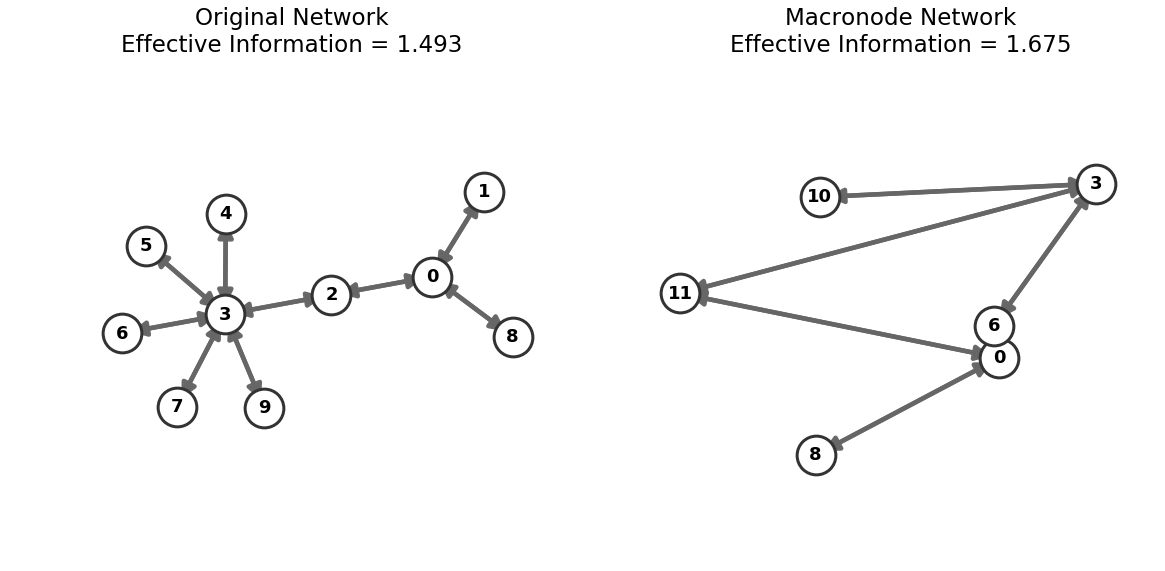

In [83]:
p0 = 0
tpm = nx.barabasi_albert_graph(10,1)

mG, mapping, G_orig = causal_emergence(tpm,p0)
MacroIDs = nx.get_node_attributes(mG, 'MacroID')
MicroIDs = [i for i,m in mapping.items() if i==m]
print(MicroIDs)

print("The original mapping is \t", dict(zip(G_orig.nodes(), G_orig.nodes())))
print("The best macro-mapping is\t", mapping)
print("The amount of causal emergence is: %.4f" % -(get_ei(G_orig,p0)-get_ei(mG,p0)))
ns = 1500
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,9))
pos = nx.kamada_kawai_layout(G_orig)
# pos = nx.circular_layout(G_orig)
nx.draw_networkx_nodes(G_orig, pos, node_color='w', node_size=ns, 
                       linewidths=3, ax=ax0).set_edgecolor('#333333')
for eij in G_orig.edges():
    i = eij[0]
    j = eij[1]
    if i==j:
        nx.draw_networkx_nodes(G_orig, pos, nodelist=[i], node_size=ns+ns*.1, node_color='w', 
                       linewidths=6, ax=ax0).set_edgecolor('dodgerblue')

nx.draw_networkx_edges(G_orig, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax0, arrowsize=30)
title = "Original Network\nEffective Information = %.3f"%(np.round(get_ei(G_orig,p0),5))
nx.draw_networkx_labels(G_orig, pos, font_size=18, font_color='k', font_weight='bold', ax=ax0)
ax0.set_title(title, size=23)
ax0.axis('off')
ax0.set_xlim(-1.15,1.15)
ax0.set_ylim(-1.15,1.15)

ns = 1500
# pos = nx.kamada_kawai_layout(G_orig)
pos = nx.spring_layout(mG, pos=pos, iterations=2)
nx.draw_networkx_nodes(mG, pos, node_color='w', node_size=ns, 
                       linewidths=3, ax=ax1).set_edgecolor('#333333')
nx.draw_networkx_edges(mG, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax1, arrowsize=30)
for eij in mG.edges():
    i = eij[0]
    j = eij[1]
    if i==j:
        nx.draw_networkx_nodes(mG, pos, nodelist=[i], node_size=(ns+ns*.1)*1.8, node_color='w',
                       linewidths=6, ax=ax1).set_edgecolor('dodgerblue')
#     if i >= G_orig.number_of_nodes()-1:
#         nx.draw_networkx_nodes(mG, pos, nodelist=[i], node_size=(ns+ns*.1)*3.8, node_color='w',
#                        linewidths=6, ax=ax1).set_edgecolor('#333333')
#     if j >= G_orig.number_of_nodes()-1:
#         nx.draw_networkx_nodes(mG, pos, nodelist=[j], node_size=(ns+ns*.1)*3.8, node_color='w',
#                        linewidths=6, ax=ax1).set_edgecolor('#333333')
        



title = "Macronode Network\nEffective Information = %.3f"%(np.round(get_ei(mG,p0),5))
nx.draw_networkx_labels(mG, pos, labels=MacroIDs, font_size=18, font_color='k', font_weight='bold', ax=ax1)
ax1.set_title(title, size=23)
ax1.axis('off')
ax1.set_xlim(-1.15,1.15)
ax1.set_ylim(-1.15,1.15)

plt.show()

In [328]:
"""
A very efficient algorithm (Algorithm U) is described by Knuth in 
the Art of Computer Programming, Volume 4, Fascicle 3B to find all 
set partitions with a given number of blocks. Since Knuth's 
algorithm is not very concise, its implementation is lengthy as well. 
Note that the implementation below moves an item among the blocks 
one at a time and need not maintain an accumulator containing all 
partial results. For this reason, no copying is required.
https://codereview.stackexchange.com/questions/1526/finding-all-k-subset-partitions
"""

def algorithm_u(ns, m):
    def visit(n, a):
        ps = [[] for i in range(m)]
        for j in range(n):
            ps[a[j + 1]].append(ns[j])
        return ps

    def f(mu, nu, sigma, n, a):
        if mu == 2:
            yield visit(n, a)
        else:
            for v in f(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                yield v
        if nu == mu + 1:
            a[mu] = mu - 1
            yield visit(n, a)
            while a[nu] > 0:
                a[nu] = a[nu] - 1
                yield visit(n, a)
        elif nu > mu + 1:
            if (mu + sigma) % 2 == 1:
                a[nu - 1] = mu - 1
            else:
                a[mu] = mu - 1
            if (a[nu] + sigma) % 2 == 1:
                for v in b(mu, nu - 1, 0, n, a):
                    yield v
            else:
                for v in f(mu, nu - 1, 0, n, a):
                    yield v
            while a[nu] > 0:
                a[nu] = a[nu] - 1
                if (a[nu] + sigma) % 2 == 1:
                    for v in b(mu, nu - 1, 0, n, a):
                        yield v
                else:
                    for v in f(mu, nu - 1, 0, n, a):
                        yield v

    def b(mu, nu, sigma, n, a):
        if nu == mu + 1:
            while a[nu] < mu - 1:
                yield visit(n, a)
                a[nu] = a[nu] + 1
            yield visit(n, a)
            a[mu] = 0
        elif nu > mu + 1:
            if (a[nu] + sigma) % 2 == 1:
                for v in f(mu, nu - 1, 0, n, a):
                    yield v
            else:
                for v in b(mu, nu - 1, 0, n, a):
                    yield v
            while a[nu] < mu - 1:
                a[nu] = a[nu] + 1
                if (a[nu] + sigma) % 2 == 1:
                    for v in f(mu, nu - 1, 0, n, a):
                        yield v
                else:
                    for v in b(mu, nu - 1, 0, n, a):
                        yield v
            if (mu + sigma) % 2 == 1:
                a[nu - 1] = 0
            else:
                a[mu] = 0
        if mu == 2:
            yield visit(n, a)
        else:
            for v in b(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                yield v

    n = len(ns)
    a = [0] * (n + 1)
    for j in range(1, m + 1):
        a[n - m + j] = j - 1
    return f(m, n, 0, n, a)

def get_all_possible_mappings(G):
    """
    Given a graph, G, return all possible macro_mappings in a list of dictionaries
    Input: G (nx.Graph)
    Output: mapping_list (list)
    """
    nodes = list(G.nodes())
    if len(nodes)>10:
        print("Go fuck yourself")
        return []

    mapping_list = []
    
    list_of_lists_of_mappings = [[nodes]]
    for i in range(2, N+1): # this must be from 2! if from 1, it breaks
        x = list(algorithm_u(nodes, i)) # key step
        for j in x:
            list_of_lists_of_mappings.append(j)
    
    for mapping in list_of_lists_of_mappings:
        out_dict = dict(zip(nodes, [-1]*len(nodes)))
        MacroID = max(nodes) # or len(nodes)
        for mac in mapping:
            if len(mac)>1:
                MacroID += 1
                for i in mac:
                    out_dict[i] = MacroID
            else:
                for i in mac:
                    out_dict[i] = i
        mapping_list.append(out_dict)
        
    return mapping_list

In [412]:
N = 10
G = nx.barabasi_albert_graph(N,1)
# nx.draw(G)

In [413]:
curr = datetime.datetime.now()
all_macro_mappings = get_all_possible_mappings(G) # i think this works
micro_ei = get_ei(G,p0)
current_best_ei = micro_ei
current_best_partition = dict(zip(list(G.nodes()), list(G.nodes())))
ei_list = []
for possible_mapping in all_macro_mappings:
    MACRO = get_macro(G, possible_mapping, p0)
    macro_ei = get_ei(MACRO, p0)
    if macro_ei > current_best_ei:
        current_best_ei = macro_ei
        current_best_partition = possible_mapping
#         ei_list.append(macro_ei)
        
    Gm = prepare_network(MACRO, p0=p0)
    ei_list.append(macro_ei)
#     print(possible_mapping, macro_ei)
diff = datetime.datetime.now()-curr

In [420]:
plt.rcParams['agg.path.chunksize'] = 10000

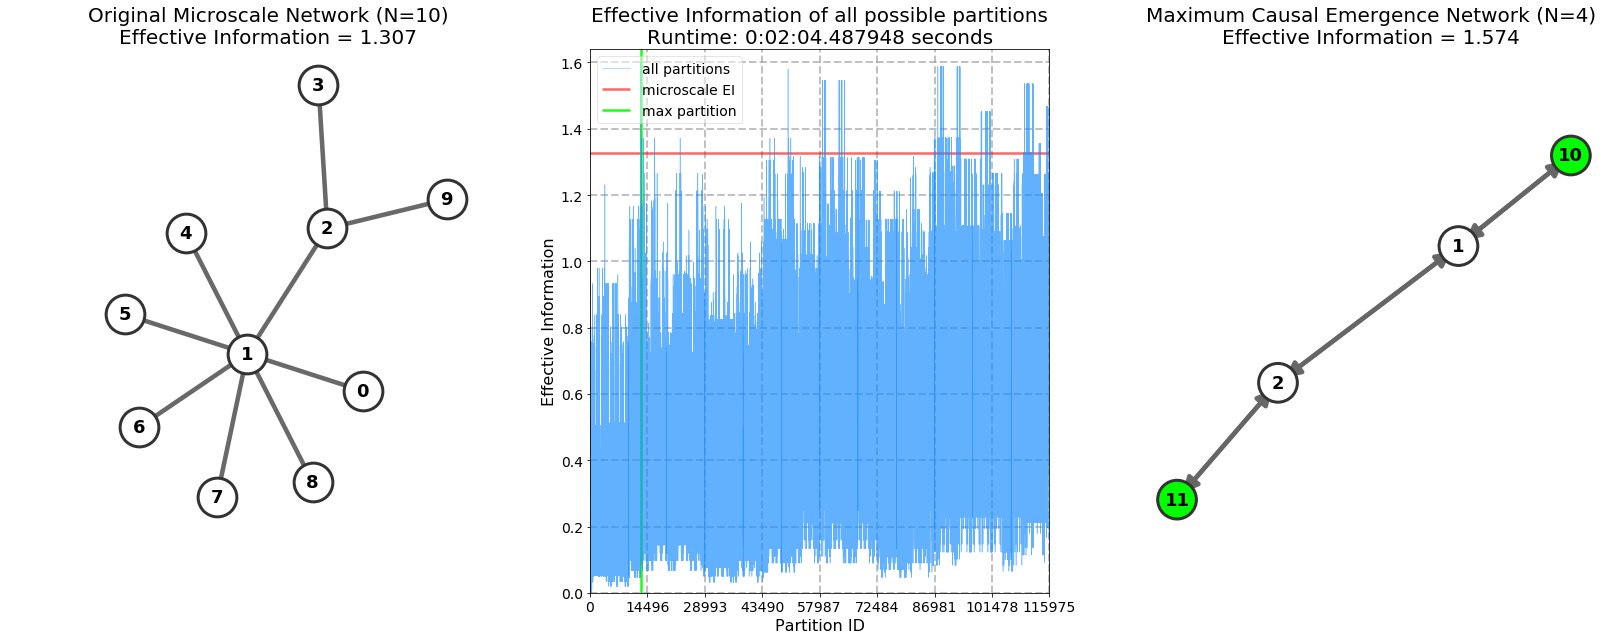

In [421]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(28,10))

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='w', node_size=ns, 
                       linewidths=3, ax=ax0).set_edgecolor('#333333')

nx.draw_networkx_edges(G, pos, edge_color="#666666",width=4.55, 
                       alpha=0.98, ax=ax0, arrowsize=30)
title0 = "Original Microscale Network (N=%i)\nEffective Information = %.3f"%(N,np.round(get_ei(G,p0),5))
nx.draw_networkx_labels(G, pos, font_size=18, font_color='k', font_weight='bold', ax=ax0)
ax0.set_title(title0, size=20)
ax0.axis('off')
ax0.set_xlim(-1.15,1.15)
ax0.set_ylim(-1.15,1.15)

ax1.plot(ei_list, color='dodgerblue', linewidth=0.5, alpha=0.7, label='all partitions')
ax1.hlines([get_ei(G,p0)], -1, len(ei_list)+1, color='red',
           linewidth=2.5, alpha=0.6, label='microscale EI')
m = max(ei_list)
ax1.vlines([i for i, j in enumerate(ei_list) if j == m], 0, 2, linestyle='-',
           color='lime', linewidth=2.5, alpha=0.9, label='max partition')
#            color='lime', linewidth=0.5, alpha=0.9, label='max partition\n%s'%current_best_partition)

ax1.grid(linewidth=2.0, linestyle='--', color='#999999', alpha=0.6)
ax1.set_xlim(-1,len(ei_list)+1)
ax1.set_ylim(0,max(ei_list)+0.025*max(ei_list))
ax1.set_yticks(np.linspace(0,m,9))
ax1.set_yticklabels(['%.1f'%i for i in np.linspace(0,m,9)], fontsize=14)
ax1.set_xticks(np.linspace(0,len(ei_list),9))
ax1.set_xticklabels(['%i'%i for i in np.linspace(0,len(ei_list),9)], fontsize=14)
ax1.set_xlabel("Partition ID", fontsize=16)
ax1.set_ylabel("Effective Information", fontsize=16)
ax1.set_title("Effective Information of all possible partitions\nRuntime: %s seconds"%diff, size=20)
ax1.legend(fontsize=14, framealpha=0.5)

MACRO = get_macro(G, current_best_partition, p0)
macro_ei = get_ei(MACRO, p0)
Gm = prepare_network(MACRO, p0=p0)
macro_node_names = dict(zip(list(Gm.nodes()),sorted(np.unique(list(current_best_partition.values())))))
Gm_plot = nx.relabel_nodes(Gm, macro_node_names)
pos = nx.spring_layout(Gm_plot, pos=pos)
cols = ['w' if i < G.number_of_nodes() else 'lime' for i in Gm_plot.nodes()]
nx.draw_networkx_nodes(Gm_plot, pos, node_color=cols, node_size=ns, 
                       linewidths=3, ax=ax2).set_edgecolor('#333333')
nx.draw_networkx_edges(Gm_plot, pos, edge_color="#666666",width=4.55, 
                       alpha=0.98, ax=ax2, arrowsize=30)
title2 = "Maximum Causal Emergence Network (N=%i)\nEffective Information = %.3f"%(\
    Gm.number_of_nodes(),np.round(macro_ei,5))
nx.draw_networkx_labels(Gm_plot, pos, font_size=18, font_color='k', font_weight='bold', ax=ax2)
ax2.set_title(title2, size=20)
ax2.axis('off')
ax2.set_xlim(-1.15,1.15)
ax2.set_ylim(-1.15,1.15)

# plt.savefig("../figs/pngs/all_possible_partitions_test2.png", dpi=425, bbox_inches='tight')
plt.show()

In [1004]:
def expand_macro(Gm, mapping, N, p0=0):
    """
    Given a macro-noded graph, Gm, and the mapping from micro to macro
    return a "null microscale graph" that has expanded the macronodes 
    into uniformly-connected micronodes.
    """
    Wout_macro = get_Wout_full(Gm, p0)
    Wout = np.zeros((len(mappp.keys()),len(mappp.keys())))

    node_assignments = np.array(list(mappp.values()))
    node_counts = np.array([np.count_nonzero(node_assignments == i) for i in node_assignments])
    nodecount_dict = dict(zip(node_assignments,node_counts))

    Wout_macro_to_Map = dict(zip(sorted(list(nodecount_dict.keys())),list(range(len(nodecount_dict)))))
    Wout_Map_to_macro = dict(zip(list(range(len(nodecount_dict))), sorted(list(nodecount_dict.keys()))))

    xx = [nodecount_dict[i] for i in Wout_macro_to_Map.keys()]

    for i in range(Wout.shape[0]):
        mac = mappp[i]
        macro_index  = Wout_macro_to_Map[mac]
        Wout_macro_i = Wout_macro[macro_index]
        Wout_micro_i = []
        for idx, num_repeat in enumerate(xx):
            for n in range(num_repeat):
                Wout_micro_i.append(Wout_macro_i[idx] / num_repeat)

        Wout[i] = Wout_micro_i

    return Wout

{0: 0, 1: 1, 2: 2, 3: 10, 4: 4, 5: 10, 6: 10, 7: 10, 8: 8, 9: 10}


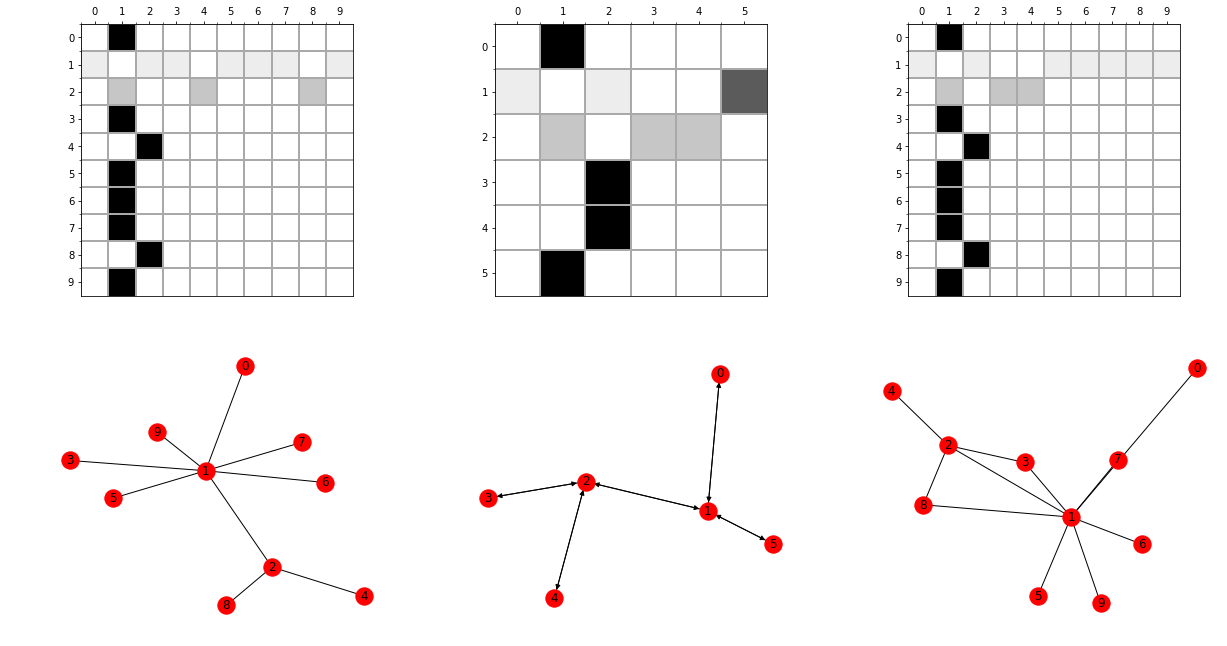

In [1027]:
N = 10
m = 1
G = nx.barabasi_albert_graph(N,m)
# G = nx.complete_graph(16)
# G.add_edges_from([(16,17),(16,18),(16,19),(16,20),(17,18),(17,19),(17,20),(18,19),(18,20),(19,20)])

Gm, mappp, G_orig = causal_emergence(G, p0, printt=False)
print(mappp)
w00 = get_Wout_full(G, p0)
w01 = expand_macro(Gm, mappp, N, p0)
inds = list(range(w01.shape[0]))
# ind_dict = dict(zip(inds, [sp.stats.entropy(w01[i]) for i in range(w01.shape[0])]))
ords = list(list(zip(*sorted(mappp.items(), key=operator.itemgetter(1))))[0])
# ords = list(list(zip(*sorted(ind_dict.items(), key=operator.itemgetter(1))))[0])

fig, ((ax00,ax01,ax02),(ax10,ax11,ax12)) = plt.subplots(2,3,figsize=(21,11))
ax00.imshow(w00, cmap='Greys')
# ax00.imshow(w00[ords], cmap='Greys')
ax00.set_xticks(np.arange(0, N, 1));
ax00.set_yticks(np.arange(0, N, 1));
ax00.set_xticklabels(np.arange(0, N, 1));
ax00.set_yticklabels(np.arange(0, N, 1));
ax00.set_xticks(np.arange(-0.5, N-0.5, 1), minor=True);
ax00.set_yticks(np.arange(-0.5, N-0.5, 1), minor=True);
ax00.grid(which='minor', color='darkgrey', linestyle='-', linewidth=2)
ax00.xaxis.tick_top()

Nm = Gm.number_of_nodes()
ax01.imshow(nx.to_numpy_array(Gm), cmap='Greys')
ax01.set_xticks(np.arange(0, Nm, 1));
ax01.set_yticks(np.arange(0, Nm, 1));
ax01.set_xticklabels(np.arange(0, Nm, 1));
ax01.set_yticklabels(np.arange(0, Nm, 1));
ax01.set_xticks(np.arange(-0.5, Nm-0.5, 1), minor=True);
ax01.set_yticks(np.arange(-0.5, Nm-0.5, 1), minor=True);
ax01.grid(which='minor', color='darkgrey', linestyle='-', linewidth=2)
ax01.xaxis.tick_top()

ax02.imshow(w01, cmap='Greys')
# ax02.imshow(w01[ords], cmap='Greys')
ax02.set_xticks(np.arange(0, N, 1));
ax02.set_yticks(np.arange(0, N, 1));
ax02.set_xticklabels(np.arange(0, N, 1));
ax02.set_yticklabels(np.arange(0, N, 1));
ax02.set_xticks(np.arange(-0.5, N-0.5, 1), minor=True);
ax02.set_yticks(np.arange(-0.5, N-0.5, 1), minor=True);
ax02.grid(which='minor', color='darkgrey', linestyle='-', linewidth=2)
ax02.xaxis.tick_top()

g00 = nx.from_numpy_array(w00)
g01 = nx.from_numpy_array(w01)

pos0 = nx.spring_layout(g00)
pos1 = nx.spring_layout(Gm )
pos2 = nx.spring_layout(g01)
nx.draw(g00, pos=pos0, ax=ax10)
nx.draw_networkx_labels(g00, pos0, ax=ax10)
nx.draw(Gm,  pos=pos1, ax=ax11)
nx.draw_networkx_labels(Gm , pos1, ax=ax11)
nx.draw(g01, pos=pos2, ax=ax12)
nx.draw_networkx_labels(g01, pos2, ax=ax12)

plt.show()

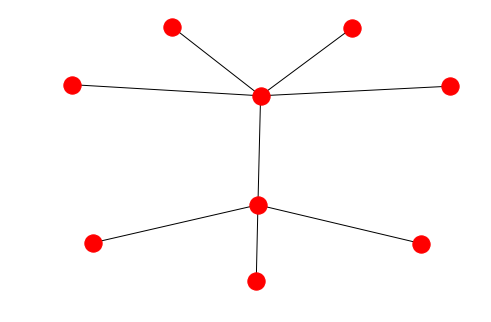

In [1020]:
N = 9
G = nx.barabasi_albert_graph(N,1)
# nx.draw(G)

In [1028]:
curr = datetime.datetime.now()
all_macro_mappings = get_all_possible_mappings(G) # i think this works
micro_ei = get_ei(G,p0)
current_best_ei = micro_ei
current_best_partition = dict(zip(list(G.nodes()), list(G.nodes())))
ei_list = []
null_list = []
null_list2 = []

for possible_mapping in all_macro_mappings:
    MACRO = get_macro(G, possible_mapping, p0)
    macro_ei = get_ei(MACRO, p0)
    try:
        MacroNull = expand_macro(MACRO, possible_mapping, N, p0)
        nacro_ei = get_ei(MacroNull, p0)
        if macro_ei > current_best_ei:
            current_best_ei = macro_ei
            current_best_partition = possible_mapping
            null_list2.append(macro_ei-nacro_ei)
            
    #         ei_list.append(macro_ei)

        null_list.append(macro_ei-nacro_ei)

        Gm = prepare_network(MACRO, p0=p0)
        ei_list.append(macro_ei)
    except:
        continue
#     print(possible_mapping, macro_ei)
diff = datetime.datetime.now()-curr

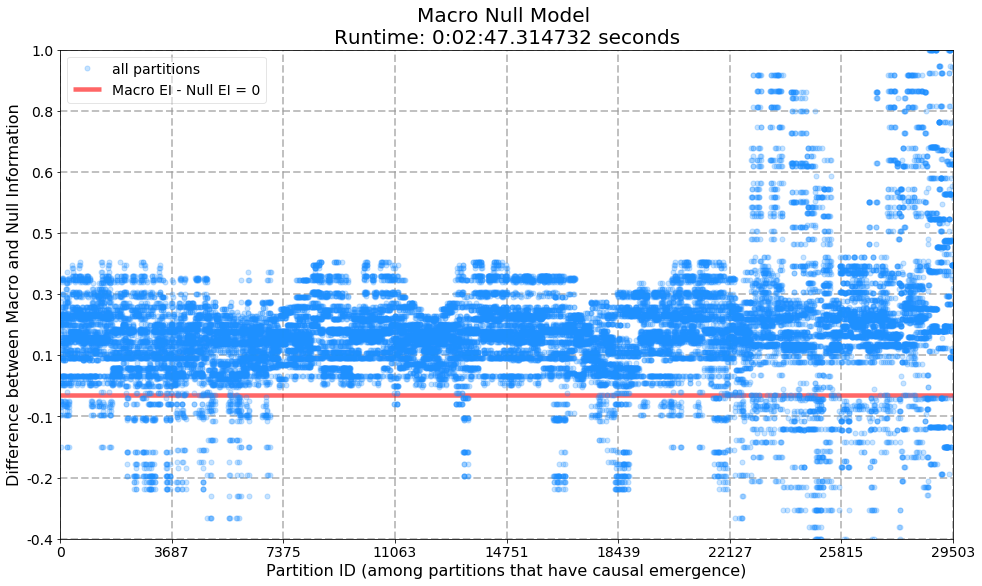

In [1037]:
fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1.plot(null_list, color='dodgerblue', linestyle='', marker='o', alpha=0.25, markersize=5, label='all partitions')
ax1.hlines(0, -1, len(ei_list)+1, color='red',
           linewidth=4.5, alpha=0.6, label='Macro EI - Null EI = 0')
m = max(null_list)
# ax1.vlines([i for i, j in enumerate(null_list) if j == m], 0, 2, linestyle='-',
#            color='lime', linewidth=2.5, alpha=0.9, label='max partition')
#            color='lime', linewidth=0.5, alpha=0.9, label='max partition\n%s'%current_best_partition)

ax1.grid(linewidth=2.0, linestyle='--', color='#999999', alpha=0.6)
ax1.set_xlim(-1,len(null_list)+1)
ax1.set_ylim(min(null_list),max(null_list))
ax1.set_yticks(np.linspace(min(null_list),max(null_list),9))
ax1.set_yticklabels(['%.1f'%i for i in np.linspace(min(null_list),max(null_list),9)], fontsize=14)
ax1.set_xticks(np.linspace(0,len(null_list),9))
ax1.set_xticklabels(['%i'%i for i in np.linspace(0,len(null_list),9)], fontsize=14)
ax1.set_xlabel("Partition ID (among partitions that have causal emergence)", fontsize=16)
ax1.set_ylabel("Difference between Macro and Null Information", fontsize=16)
ax1.set_title("Macro Null Model \nRuntime: %s seconds"%diff, size=20)
ax1.legend(fontsize=14, framealpha=0.5)

# plt.savefig("../figs/pngs/null_modelz2.png", dpi=425, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1.plot(null_list, color='dodgerblue', linestyle='', marker='o', alpha=0.25, markersize=5, label='all partitions')
ax1.hlines(0, -1, len(ei_list)+1, color='red',
           linewidth=4.5, alpha=0.6, label='Macro EI - Null EI = 0')
m = max(null_list)
# ax1.vlines([i for i, j in enumerate(null_list) if j == m], 0, 2, linestyle='-',
#            color='lime', linewidth=2.5, alpha=0.9, label='max partition')
#            color='lime', linewidth=0.5, alpha=0.9, label='max partition\n%s'%current_best_partition)

ax1.grid(linewidth=2.0, linestyle='--', color='#999999', alpha=0.6)
ax1.set_xlim(-1,len(null_list)+1)
ax1.set_ylim(min(null_list),max(null_list))
ax1.set_yticks(np.linspace(min(null_list),max(null_list),9))
ax1.set_yticklabels(['%.1f'%i for i in np.linspace(min(null_list),max(null_list),9)], fontsize=14)
ax1.set_xticks(np.linspace(0,len(null_list),9))
ax1.set_xticklabels(['%i'%i for i in np.linspace(0,len(null_list),9)], fontsize=14)
ax1.set_xlabel("Partition ID (among partitions that have causal emergence)", fontsize=16)
ax1.set_ylabel("Difference between Macro and Null Information", fontsize=16)
ax1.set_title("Macro Null Model \nRuntime: %s seconds"%diff, size=20)
ax1.legend(fontsize=14, framealpha=0.5)

# plt.savefig("../figs/pngs/null_modelz2.png", dpi=425, bbox_inches='tight')
plt.show()

In [1049]:
A = np.array([[0.99, 0.01,    0.0, 0.0, 0.],
              [0.0,  1/3-0.01, 1/3, 1/3, .01],
              [0.0,  1/3,      1/3, 1/3, 0.0], 
              [0.0,  1/3,      1/3, 1/3, 0.0], 
              [0.0,  0.0,      0.0, 0.0, 1.0]])

In [1051]:
print(get_ei(A,p0=0))

1.341803655704979


In [1053]:
Gm, mm, G_o = causal_emergence(A, p0)

Starting with this tpm:
 [[0.99   0.01   0.     0.     0.    ]
 [0.     0.3233 0.3333 0.3333 0.01  ]
 [0.     0.3333 0.3333 0.3333 0.    ]
 [0.     0.3333 0.3333 0.3333 0.    ]
 [0.     0.     0.     0.     1.    ]]

Search started... current_ei = 1.3418
001 ... 3 ... macro size = 5
just found successful macro grouping... current_ei = 1.4636
just found successful macro grouping... current_ei = 1.5473
002 ... 2 ... macro size = 3
003 ... 1 ... macro size = 3
004 ... 0 ... macro size = 3
005 ... 4 ... macro size = 3


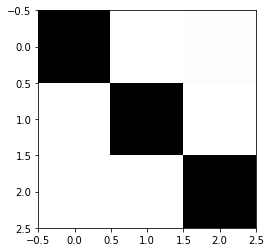

In [1055]:
plt.imshow(get_Wout_full(Gm), cmap='bone_r')

In [1056]:
# nx.strongly_connected_components()

NetworkXNotImplemented: not implemented for undirected type

In [956]:
import operator

[2.7720843672410393,
 2.7720843672410393,
 2.7720843672410393,
 2.7720843672410393,
 2.7720843672410393,
 2.7720843672410393,
 2.7720843672410393,
 2.70805020110221,
 2.7720843672410393,
 2.70805020110221,
 2.7720843672410393,
 2.7720843672410393,
 2.70805020110221,
 2.7720843672410393,
 2.7720843672410393,
 2.7720843672410393,
 1.3862943611198906,
 1.3862943611198906,
 1.3862943611198906,
 1.3862943611198906,
 1.3862943611198906]

In [647]:
inds = list(range(Wout_macro.shape[0]))
new_ind = [i for i in inds if i!=curr_macro] 
top_right_array = np.array(np.ones((macro_dict[mac],top_left_matrix.shape[0])) * 
                           Wout_macro[new_ind,new_ind]/macro_dict[mac]).T


In [649]:
np.ones((macro_dict[mac],top_left_matrix.shape[0]))

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [652]:
Wout_macro[new_ind,new_ind]

array([0., 0., 0., 0., 0.])

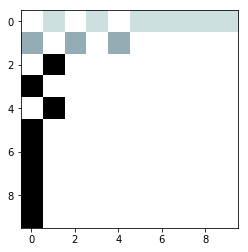

In [540]:
plt.imshow(expand_macro(x, y, len(y.values()), p0), cmap='bone_r')
plt.imshow(expand_macro(x, y, len(y.values()), p0), cmap='bone_r')

In [531]:
n_micros = nmicros
bottom_right_clique = np.ones((macro_dict[mac],macro_dict[mac])) * WMin / macro_dict[mac]
bottom_left_array = WMout * np.ones((n_micros,len(WMout)))
bottom_rows = np.hstack((bottom_left_array, bottom_right_clique))

top_left_matrix = Wout_macro[:curr_macro,:curr_macro]
top_right_array = np.array(np.ones((top_left_matrix.shape[0],nmicros)) * 
                           Wout_macro[:,-1][:-1]/nmicros).T
top_rows = np.hstack((top_left_matrix, top_right_array))

Wout = np.vstack((top_rows, bottom_rows))

In [534]:
np.round(np.vstack((top_rows, bottom_rows)),2)

array([[0.  , 0.14, 0.  , 0.14, 0.  , 0.14, 0.14, 0.14, 0.14, 0.14],
       [0.33, 0.  , 0.33, 0.  , 0.33, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [530]:
top_right_array

array([[0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [515]:
top_left_matrix = Wout_macro[:curr_macro,:curr_macro]
top_right_array = np.ones((top_left_matrix.shape[0],nmicros)) * Wout_macro[:,-1]/nmicros


array([[0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [524]:
Wout_macro[:,-1][:-1]

array([0.71428571, 0.        , 0.        , 0.        , 0.        ])

In [500]:
bottom_right_clique = np.ones((macro_dict[mac],macro_dict[mac])) * WMin / macro_dict[mac]
bottom_left_array = WMout * np.ones((nmicros,len(WMout)))


In [523]:
np.round(Wout_macro[:curr_macro,:curr_macro],2)
np.round(Wout_macro,2)

array([[0.  , 0.14, 0.  , 0.14, 0.  , 0.71],
       [0.33, 0.  , 0.33, 0.  , 0.33, 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [446]:
max_node_id = max(list(mapping.keys()))
macro_ids = np.array(list(mapping.values())) > max_node_id
macronodes = np.array(list(mapping.values()))[macro_ids]
macronode_ids = list(np.unique(macronodes))
macronode_ids

[10]

In [471]:
nmicros = Wout_macro.shape[0] - len(macronode_ids)
curr_micros = nmicros
for idx, mac in enumerate(macronode_ids):
    curr_macro = nmicros + idx
    micros_to_add = list(range(curr_micros, curr_micros+macro_dict[mac]))


In [472]:
micros_to_add

[5, 6, 7, 8, 9]

In [469]:
len(macronode_ids)

1

In [465]:
for idx, mac in enumerate(macronode_ids):
    print(idx,mac)

0 10


In [460]:
z.nodes(data=True)

NodeDataView({0: {'mean_EI_change': 0.13087519677615636, 'max_EI_change': 0.2551694561302946, 'order': 7}, 1: {'mean_EI_change': -0.14487514164755172, 'max_EI_change': -0.026624408373008057, 'order': 4}, 2: {'mean_EI_change': -0.23992115756435795, 'max_EI_change': -0.11615589747078525, 'order': 1}, 3: {'mean_EI_change': 0.02588316899721388, 'max_EI_change': 0.21473918427831662, 'order': 9}, 4: {'mean_EI_change': 0.07973602026965164, 'max_EI_change': 0.2551694561302946, 'order': 2}, 5: {'mean_EI_change': 0.13087519677615636, 'max_EI_change': 0.2551694561302946, 'order': 3}, 6: {'mean_EI_change': 0.13087519677615636, 'max_EI_change': 0.2551694561302946, 'order': 5}, 7: {'mean_EI_change': 0.13087519677615636, 'max_EI_change': 0.2551694561302946, 'order': 8}, 8: {'mean_EI_change': 0.1845975029201257, 'max_EI_change': 0.2551694561302946, 'order': 6}, 9: {'mean_EI_change': -0.2514211737296465, 'max_EI_change': -0.13857135793254116, 'order': 0}})

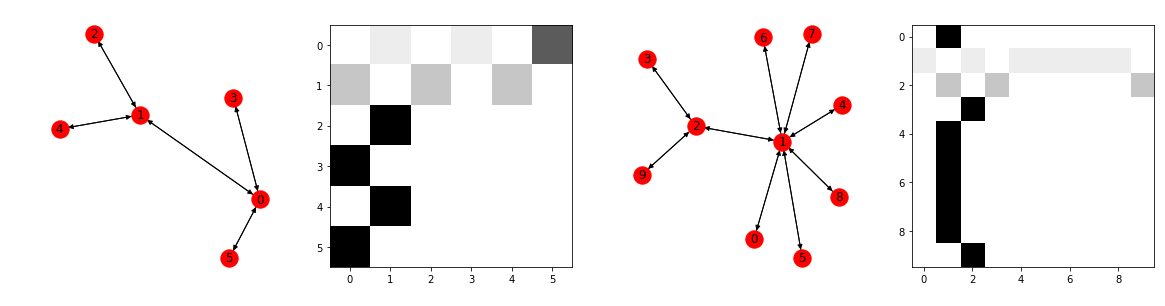

In [464]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(20,5))
pos0 = nx.spring_layout(x)
nx.draw(x, pos=pos0, ax=ax0)
nx.draw_networkx_labels(x, pos=pos0, ax=ax0)
ax1.imshow(get_Wout_full(x, p0), cmap='Greys')
pos2 = nx.spring_layout(z)
nx.draw(z, pos=pos2, ax=ax2)
nx.draw_networkx_labels(z, pos=pos2, ax=ax2)
ax3.imshow(get_Wout_full(z, p0), cmap='Greys')

In [456]:
y

{0: 10, 1: 1, 2: 2, 3: 3, 4: 10, 5: 10, 6: 10, 7: 10, 8: 8, 9: 9}

In [449]:
max_node_id = max(list(mapping.keys()))
macro_ids = np.array(list(mapping.values())) > max_node_id
macronodes = np.array(list(mapping.values()))[macro_ids]
macronode_ids = list(np.unique(macronodes))
if len(macronode_ids):
    count_macronodes = [np.count_nonzero(macronodes == i) for i in macronode_ids]
    macro_dict = dict(zip(macronode_ids, count_macronodes))
macro_dict

{10: 5}

[5]

In [441]:
np.array(list(mapping.values()))[macronode_ids]

array([10, 10, 10, 10, 10])

In [439]:
mapping=y

In [440]:
max_node_id = max(list(mapping.keys()))
macronode_ids = np.array(list(mapping.values())) > max_node_id
macronodes = list(np.unique(np.array(list(mapping.values()))[macronode_ids]))
macronodes

[10]

In [423]:
get_macro(G, possible_mapping, p0)

array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.14285714, 0.        , 0.14285714, 0.        , 0.14285714,
        0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.        ],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.       

In [430]:
x, y, z = causal_emergence(G, p0)

Starting with this tpm:
 [[0.     1.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.1429 0.     0.1429 0.     0.1429 0.1429 0.1429 0.1429 0.1429 0.    ]
 [0.     0.3333 0.     0.3333 0.     0.     0.     0.     0.     0.3333]
 [0.     0.     1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.     0.     0.    ]]

Search started... current_ei = 1.3068
001 ... 9 ... macro size = 10
002 ... 2 ... macro size = 10
003 ... 4 ... macro size = 10
just found successful macro grouping... current_ei = 1.3737
just found successful macro grouping... current_ei = 1.

In [433]:
idzzz = np.array(list(y.values())) > max(list(y.keys()))

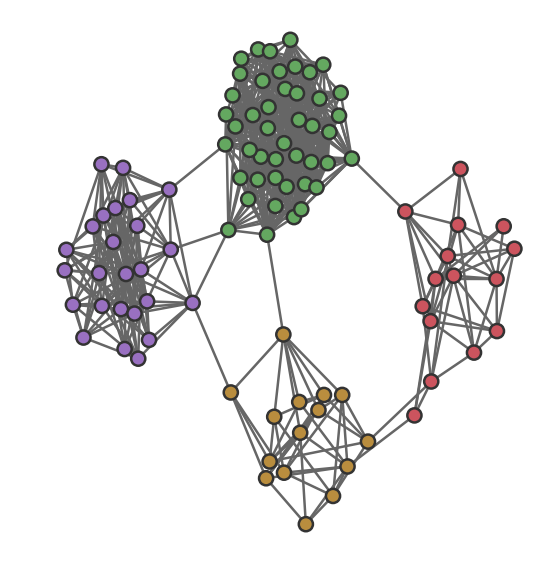

In [13]:
size_dist = np.array([3.0, 2.0, 2.5, 2.0])
ncomms = 4
N = 100; p=0.2; q=0.002
size_dist = softmax(size_dist)
G = random_clustered_network(N, p, q, size_dist)
# G = nx.barabasi_albert_graph(N, 1)

colors = ["#64a860", "#9970c1", "#b98d3e", "#cc545e"]
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]

plt.figure(figsize=(9,10))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=200, 
                       linewidths=2.5, node_color=nodecols).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5)
plt.axis('off')

# plt.savefig("../figs/pngs/ClusteredNetwork.png", dpi=425, bbox_inches='tight')
plt.show()